In [56]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score,
    roc_curve, brier_score_loss
)
from sklearn.calibration import calibration_curve

# Import custom models
# Removed old path hack; using package imports))
from llm_prior_project.priors.target_informed_model import TargetInformedModel
from llm_prior_project.priors.target_elicitor import LLMTargetElicitor

np.random.seed(42)


In [58]:
# loading the data 
def load_heart_dataset(path, features, outcome="num"):
    columns = [
        "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
        "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
    ]
    df = pd.read_csv(path, header=None, names=columns, na_values="?")
    df[outcome] = (df[outcome] > 0).astype(int)
    df = df[features + [outcome]].dropna()
    return df[features], df[outcome]

features = ["age", "sex", "trestbps", "chol", "thalach", "oldpeak"]

X, y = load_heart_dataset("data/heart+disease/processed.hungarian.data", features)
X_cleveland, y_cleveland = load_heart_dataset("data/heart+disease/processed.cleveland.data", features)

print("Hungarian:", X.shape, "Cleveland:", X_cleveland.shape)


KeyError: "None of [Index(['cp', 'restecg'], dtype='object')] are in the [columns]"

custom_prompt = """
You are an expert in biostatistics and cardiovascular epidemiology.  
Your task is to propose *target coefficient values* for a logistic regression model predicting **coronary artery disease (CAD)**.  

### Dataset Context
- Source: UCI Heart Disease dataset (Cleveland/Hungarian variants).  
- Outcome variable: `num` (binary, 0 = healthy, 1 = CAD).  
- Prevalence in dataset: ~46% CAD cases (higher than population baseline).  
- Model type: **logistic regression** (coefficients are on the log-odds scale).  
- Purpose: These coefficient targets will be used as shrinkage points in a custom **target-informed ridge regression**.  

### Features Provided
- `age`: Age in years. CAD risk increases with age.  
- `sex`: Biological sex (1 = male, 0 = female). Males typically have higher CAD risk.  
- `trestbps`: Resting blood pressure (mmHg) on hospital admission. Higher values are risk factors.  
- `chol`: Serum cholesterol level (mg/dl). High cholesterol is a risk factor, but the effect may be modest.  
- `thalach`: Maximum heart rate achieved during exercise (bpm). Higher capacity is protective.  
- `oldpeak`: ST depression induced by exercise relative to rest (mm). Larger values indicate ischemia and higher CAD risk.  

### Instructions
1. **Use domain reasoning**: Base your targets on known epidemiological evidence and pathophysiology.  
   - Example: age and male sex should have positive coefficients, thalach should have negative.  
2. **Provide magnitudes**: Coefficients should reflect relative importance of risk factors (e.g., age smaller per-unit effect than oldpeak, but still consistently positive).  
3. **Scale**: Coefficients must be given on the *log-odds scale* (logistic regression).  
   - Small effects ≈ 0.05–0.2, moderate ≈ 0.3–0.6, large ≥ 0.8.  
4. **Reflection**: Before giving the JSON output, write a short paragraph of reasoning for each feature explaining *why* you chose the coefficient value.  
5. **Final JSON Output**: Output must be strictly JSON only, with no reasoning inside.  

### JSON Format (STRICT)
```
{{
  "domain": "cardiovascular disease risk",
  "targets": {{
    "age": <float>,
    "sex": <float>,
    "trestbps": <float>,
    "chol": <float>,
    "thalach": <float>,
    "oldpeak": <float>
  }}
}}
```

⚠️ The JSON must be the very last part of your response.  
No extra commentary after the JSON block.
"""


elicitor = LLMTargetElicitor(model_name="gpt-4")
result = elicitor.get_targets_with_prompt(custom_prompt, features)

if result:
    targets = result["targets"]
    print("Extracted targets:", targets)
else:
    targets = [0.0] * len(features)

In [44]:
custom_prompt = """

You are an expert in **biostatistics and cardiovascular epidemiology**.  
For the **target-informed logistic regression model** provided below, which predicts coronary artery disease (CAD), your task is to propose and justify suitable target values for the regression coefficients.  

Unlike standard ridge regression, which shrinks coefficients toward **zero**, this method shrinks coefficients toward **pre-specified targets** $\mu = (\mu_1, \ldots, \mu_p)$, based on domain knowledge.  

---

**Model Details:**  
- Response: $y \in \{0,1\}$ (0 = healthy, 1 = CAD)  
- Linear Predictor:  

\[
\eta = \beta_0 + \beta_1 \cdot \text{age} + \beta_2 \cdot \text{sex} + \beta_3 \cdot \text{trestbps} + \beta_4 \cdot \text{chol} + \beta_5 \cdot \text{thalach} + \beta_6 \cdot \text{oldpeak}
\]

- Prediction:  

\[
P(y=1|X) = \frac{1}{1 + \exp(-\eta)}
\]

- Objective Function (Target-Informed Ridge Penalty):  

\[
\min_\beta \; - \log L(\beta \,|\, X,y) + \alpha \sum_{j=1}^p (\beta_j - \mu_j)^2
\]

where $\mu_j$ are the **target values** you will propose.  

---

**Predictor Details:**  
- `age`: in years  
- `sex`: categorical (1 = male; 0 = female)  
- `trestbps`: resting blood pressure (mm Hg on admission)  
- `chol`: serum cholesterol (mg/dl)  
- `thalach`: maximum heart rate achieved (bpm)  
- `oldpeak`: ST depression induced by exercise relative to rest (mm)  

---

**Your Response Should:**  

1. **Leverage Knowledge & Simulate Literature Use**  
   - Briefly state how you use your epidemiological knowledge (e.g., Framingham Study, MONICA project, meta-analyses) to inform coefficient expectations.  
   - Do *not* rely on the Cleveland Heart Disease dataset, but instead general domain knowledge.  

2. **Propose Target Coefficients ($\mu_j$)**  
   - Provide target values $\mu_j$ for each predictor, representing the expected effect on the log-odds of CAD.  
   - Justify the direction (positive/negative) and plausible magnitude of each coefficient in natural language.  

3. **Rationale for Each Target**  
   - For each predictor, explain why the coefficient should be positive/negative, and roughly how large, based on prior evidence.  
   - For $\beta_0$, clarify its interpretation (baseline log-odds when all predictors are zero) and how you approximate it.  

4. **Uncertainty & Strength of Belief**  
   - Discuss how confident you are about each target. Which ones are well-established (e.g., age, sex), and which are more uncertain (e.g., cholesterol in small hospital samples)?  
   - If useful, you may also describe an alternative “weaker” set of targets closer to zero, to represent more cautious shrinkage.  

---

**Output Format:**  
After providing your reasoning in detail, end your answer with a JSON object summarizing the chosen target values only:  

```json
{
  "targets": {
    "age": ... ,
    "sex": ... ,
    "trestbps": ... ,
    "chol": ... ,
    "thalach": ... ,
    "oldpeak": ...
  }
}
```

---


"""


elicitor = LLMTargetElicitor(model_name="gpt-4")
result = elicitor.get_targets_with_prompt(custom_prompt, features)

if result:
    targets = result["targets"]
    print("Extracted targets:", targets)
else:
    targets = [0.0] * len(features)

Using user-crafted prompt
Feature names expected: ['age', 'sex', 'trestbps', 'chol', 'thalach', 'oldpeak']
Prompt length: 2934 characters
Prompt validation: PASSED
Calling LLM API...
Got LLM response (2977 characters)
Response preview: 1. **Leverage Knowledge & Simulate Literature Use**  
   The Framingham Heart Study, MONICA project, and various meta-analyses have provided valuable insights into the risk factors for coronary artery...
Parsing LLM response...
Successfully extracted targets: [0.05, 0.5, 0.02, 0.002, -0.02, 0.5]
Extracted targets: [0.05, 0.5, 0.02, 0.002, -0.02, 0.5]


In [45]:
#targets = [0.05, 1.2, 0.2, 0.1, -0.4, 0.3]

In [46]:
def evaluate_models(model, baseline, X, y):
    """
    Evaluate baseline and informed models on given data.
    Works with either numpy arrays or pandas DataFrames.
    """
    # Ensure numpy arrays
    X = np.asarray(X)
    y = np.asarray(y)

    # Baseline (sklearn logistic regression)
    baseline_probs = baseline.predict_proba(X)[:, 1]

    # Informed model already returns probabilities
    informed_probs = model.predict(X)

    return {
        "baseline_accuracy": accuracy_score(y, (baseline_probs > 0.5).astype(int)),
        "baseline_log_loss": log_loss(y, baseline_probs),
        "baseline_auc": roc_auc_score(y, baseline_probs),
        "informed_accuracy": accuracy_score(y, (informed_probs > 0.5).astype(int)),
        "informed_log_loss": log_loss(y, informed_probs),
        "informed_auc": roc_auc_score(y, informed_probs)
    }


def cross_val_evaluate(X, y, feature_names, targets, alpha=1.0, n_splits=5):
    """
    Compare baseline vs target-informed logistic regression using cross-validation.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Baseline logistic regression
        baseline = LogisticRegression(max_iter=1000).fit(X_train, y_train)
        
        # Target-informed logistic regression
        informed = TargetInformedModel(alpha=alpha, model_type="logistic").fit(
            X_train, y_train, feature_names=feature_names, targets=targets
        )
        
        results.append(evaluate_models(informed, baseline, X_test, y_test))
    
    return pd.DataFrame(results)


def cross_val_grid_alphas(X, y, feature_names, targets, alphas, n_splits=5):
    """
    Run cross-validation across multiple alpha values for TargetInformedModel.
    Returns per-fold results, a summary table, and the best alpha.
    """
    all_results = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for alpha in alphas:
        cv_results = cross_val_evaluate(
            X, y, feature_names, targets, alpha=alpha, n_splits=n_splits
        )
        cv_results["alpha"] = alpha
        all_results.append(cv_results)

    results = pd.concat(all_results, ignore_index=True)
    summary = results.groupby("alpha").mean()

    # Select alpha with lowest informed log_loss
    best_alpha = summary["informed_log_loss"].idxmin()
    print("\nCross-validation summary:")
    print(summary)
    print("\nSelected alpha (by log_loss):", best_alpha)

    return results, summary, best_alpha


In [47]:
alphas = [0.01, 0.1, 0.5, 1, 2, 5, 10]
grid_results, summary, best_alpha = cross_val_grid_alphas(
    X.values, y.values, features, targets, alphas, n_splits=5
)


Cross-validation summary:
       baseline_accuracy  baseline_log_loss  baseline_auc  informed_accuracy  \
alpha                                                                          
0.01            0.814815           0.450018      0.849259           0.744444   
0.10            0.814815           0.450018      0.849259           0.744444   
0.50            0.814815           0.450018      0.849259           0.740741   
1.00            0.814815           0.450018      0.849259           0.744444   
2.00            0.814815           0.450018      0.849259           0.744444   
5.00            0.814815           0.450018      0.849259           0.748148   
10.00           0.814815           0.450018      0.849259           0.744444   

       informed_log_loss  informed_auc  
alpha                                   
0.01            0.517926      0.849248  
0.10            0.517596      0.850419  
0.50            0.517310      0.851019  
1.00            0.518183      0.849853  
2.00  

In [48]:
print(best_alpha)
baseline = LogisticRegression(max_iter=1000).fit(X, y)
informed = TargetInformedModel(alpha=best_alpha, model_type="logistic").fit(
    X.values, y.values, feature_names=features, targets=targets
)

metrics = evaluate_models(informed, baseline, X, y)
print("Hungarian (in-sample):\n", pd.DataFrame([metrics]))


0.5
Hungarian (in-sample):
    baseline_accuracy  baseline_log_loss  baseline_auc  informed_accuracy  \
0           0.825926           0.425129      0.861269           0.766667   

   informed_log_loss  informed_auc  
0           0.492338      0.859921  


/Users/solvelangseth/miniconda3/envs/llm-stats/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [49]:
cv_results = cross_val_evaluate(X.values, y.values, features, targets, alpha=1.0, n_splits=5)
print("Cross-validation (Hungarian):")
print(cv_results)
print("\nAverage:", cv_results.mean())


Cross-validation (Hungarian):
   baseline_accuracy  baseline_log_loss  baseline_auc  informed_accuracy  \
0           0.851852           0.377997      0.901471           0.722222   
1           0.722222           0.495852      0.832353           0.722222   
2           0.759259           0.657456      0.701471           0.685185   
3           0.907407           0.320908      0.925000           0.851852   
4           0.833333           0.397875      0.886003           0.740741   

   informed_log_loss  informed_auc  
0           0.492891      0.908824  
1           0.536875      0.827941  
2           0.699543      0.705882  
3           0.388577      0.922059  
4           0.473028      0.884560  

Average: baseline_accuracy    0.814815
baseline_log_loss    0.450018
baseline_auc         0.849259
informed_accuracy    0.744444
informed_log_loss    0.518183
informed_auc         0.849853
dtype: float64


In [50]:
baseline = LogisticRegression(max_iter=1000).fit(X, y)
informed = TargetInformedModel(alpha=1.0, model_type="logistic").fit(
    X.values, y.values, feature_names=features, targets=targets
)

baseline_proba = baseline.predict_proba(X_cleveland)[:, 1]
informed_proba = informed.predict(X_cleveland.values)

print("=== Cleveland Generalization (Hungarian-trained) ===")
print(f"Baseline  -> Acc: {accuracy_score(y_cleveland, (baseline_proba>0.5)):.3f}  "
      f"LogLoss: {log_loss(y_cleveland, baseline_proba):.3f}  "
      f"AUC: {roc_auc_score(y_cleveland, baseline_proba):.3f}")
print(f"Informed  -> Acc: {accuracy_score(y_cleveland, (informed_proba>0.5)):.3f}  "
      f"LogLoss: {log_loss(y_cleveland, informed_proba):.3f}  "
      f"AUC: {roc_auc_score(y_cleveland, informed_proba):.3f}")


=== Cleveland Generalization (Hungarian-trained) ===
Baseline  -> Acc: 0.749  LogLoss: 0.558  AUC: 0.805
Informed  -> Acc: 0.716  LogLoss: 0.602  AUC: 0.799


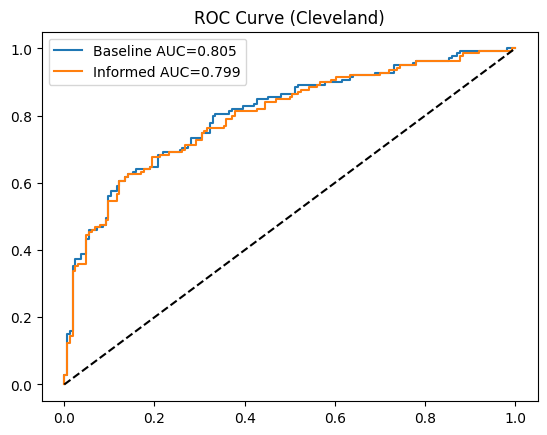

In [51]:
fpr_base, tpr_base, _ = roc_curve(y_cleveland, baseline_proba)
fpr_inf, tpr_inf, _ = roc_curve(y_cleveland, informed_proba)

plt.figure()
plt.plot(fpr_base, tpr_base, label=f"Baseline AUC={roc_auc_score(y_cleveland, baseline_proba):.3f}")
plt.plot(fpr_inf, tpr_inf, label=f"Informed AUC={roc_auc_score(y_cleveland, informed_proba):.3f}")
plt.plot([0,1],[0,1],"k--"); plt.legend(); plt.title("ROC Curve (Cleveland)")
plt.show()


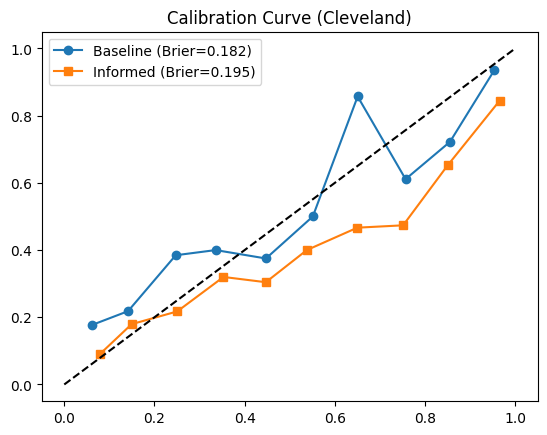

In [52]:
prob_true_base, prob_pred_base = calibration_curve(y_cleveland, baseline_proba, n_bins=10)
prob_true_inf, prob_pred_inf = calibration_curve(y_cleveland, informed_proba, n_bins=10)

plt.figure()
plt.plot(prob_pred_base, prob_true_base, "o-", label=f"Baseline (Brier={brier_score_loss(y_cleveland, baseline_proba):.3f})")
plt.plot(prob_pred_inf, prob_true_inf, "s-", label=f"Informed (Brier={brier_score_loss(y_cleveland, informed_proba):.3f})")
plt.plot([0,1],[0,1],"k--"); plt.legend(); plt.title("Calibration Curve (Cleveland)")
plt.show()

In [53]:
# %%
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, brier_score_loss
)

def cross_val_diagnostics(X, y, feature_names, targets, alpha=1.0, n_splits=5, random_state=42):
    """
    Run cross-validation for baseline vs informed logistic regression.
    Collects: accuracy, log_loss, AUC, Brier score, and coefficients per fold.
    Returns: (metrics_df, coef_df)
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    all_metrics = []
    all_coefs = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Baseline logistic regression
        baseline = LogisticRegression(max_iter=1000).fit(X_train, y_train)
        baseline_probs = baseline.predict_proba(X_test)[:, 1]

        # Target-informed logistic regression
        informed = TargetInformedModel(alpha=alpha, model_type="logistic").fit(
            X_train, y_train, feature_names=feature_names, targets=targets
        )
        informed_probs = informed.predict(X_test)

        # Metrics
        all_metrics.append({
            "fold": fold,
            "baseline_accuracy": accuracy_score(y_test, (baseline_probs > 0.5)),
            "baseline_log_loss": log_loss(y_test, baseline_probs),
            "baseline_auc": roc_auc_score(y_test, baseline_probs),
            "baseline_brier": brier_score_loss(y_test, baseline_probs),
            "informed_accuracy": accuracy_score(y_test, (informed_probs > 0.5)),
            "informed_log_loss": log_loss(y_test, informed_probs),
            "informed_auc": roc_auc_score(y_test, informed_probs),
            "informed_brier": brier_score_loss(y_test, informed_probs),
        })

        # Coefficients
        all_coefs.append({
            "fold": fold, "model": "baseline", **dict(zip(feature_names, baseline.coef_[0]))
        })
        all_coefs.append({
            "fold": fold, "model": "informed", **dict(zip(feature_names, informed.coef_))
        })

    metrics_df = pd.DataFrame(all_metrics)
    coef_df = pd.DataFrame(all_coefs)

    return metrics_df, coef_df


# %% Example usage
cv_metrics, cv_coefs = cross_val_diagnostics(
    X.values, y.values, features, targets, alpha=1.0, n_splits=5
)

print("Cross-validation metrics (per fold):")
print(cv_metrics)

print("\nAverage metrics:")
print(cv_metrics.drop(columns="fold").mean())

print("\nCoefficient snapshots:")
print(cv_coefs.head())


Cross-validation metrics (per fold):
   fold  baseline_accuracy  baseline_log_loss  baseline_auc  baseline_brier  \
0     1           0.851852           0.377997      0.901471        0.115592   
1     2           0.722222           0.495852      0.832353        0.166425   
2     3           0.759259           0.657456      0.701471        0.196117   
3     4           0.907407           0.320908      0.925000        0.093970   
4     5           0.833333           0.397875      0.886003        0.126358   

   informed_accuracy  informed_log_loss  informed_auc  informed_brier  
0           0.722222           0.492892      0.908824        0.168216  
1           0.722222           0.536879      0.827941        0.180584  
2           0.685185           0.699544      0.705882        0.219792  
3           0.851852           0.388577      0.922059        0.124187  
4           0.740741           0.473028      0.884560        0.159578  

Average metrics:
baseline_accuracy    0.814815
baseline

In [54]:
# %%
# --- Per-fold metrics comparison ---
metrics = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]

    baseline = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    informed = TargetInformedModel(alpha=1.0, model_type="logistic").fit(
        X_train, y_train, feature_names=features, targets=targets
    )

    # Predictions
    baseline_probs = baseline.predict_proba(X_test)[:, 1]
    informed_probs = informed.predict(X_test)

    metrics.append({
        "fold": fold,
        "baseline_acc": accuracy_score(y_test, (baseline_probs > 0.5)),
        "informed_acc": accuracy_score(y_test, (informed_probs > 0.5)),
        "baseline_auc": roc_auc_score(y_test, baseline_probs),
        "informed_auc": roc_auc_score(y_test, informed_probs),
        "baseline_logloss": log_loss(y_test, baseline_probs),
        "informed_logloss": log_loss(y_test, informed_probs),
    })

    # Coefficient shifts
    coef_delta = pd.Series(informed.coef_ - baseline.coef_[0], index=features)
    print(f"\n=== Fold {fold} ===")
    print("Metric differences (Informed - Baseline):")
    print(pd.Series(metrics[-1]).drop("fold") - pd.Series({
        "baseline_acc": metrics[-1]["baseline_acc"],
        "informed_acc": metrics[-1]["baseline_acc"],
        "baseline_auc": metrics[-1]["baseline_auc"],
        "informed_auc": metrics[-1]["baseline_auc"],
        "baseline_logloss": metrics[-1]["baseline_logloss"],
        "informed_logloss": metrics[-1]["baseline_logloss"]
    }))
    print("\nCoefficient shifts:")
    print(coef_delta.round(3))

metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metric comparison:")
print(metrics_df)
print("\nAverage differences:")
print(metrics_df.mean(numeric_only=True).to_dict())



=== Fold 1 ===
Metric differences (Informed - Baseline):
baseline_acc        0.000000
informed_acc       -0.129630
baseline_auc        0.000000
informed_auc        0.007353
baseline_logloss    0.000000
informed_logloss    0.114889
dtype: float64

Coefficient shifts:
age        -0.005
sex        -0.097
trestbps    0.002
chol       -0.000
thalach     0.002
oldpeak     0.149
dtype: float64

=== Fold 2 ===
Metric differences (Informed - Baseline):
baseline_acc        0.000000
informed_acc        0.000000
baseline_auc        0.000000
informed_auc       -0.004412
baseline_logloss    0.000000
informed_logloss    0.041022
dtype: float64

Coefficient shifts:
age        -0.005
sex        -0.110
trestbps    0.002
chol       -0.000
thalach     0.002
oldpeak     0.149
dtype: float64

=== Fold 3 ===
Metric differences (Informed - Baseline):
baseline_acc        0.000000
informed_acc       -0.074074
baseline_auc        0.000000
informed_auc        0.004412
baseline_logloss    0.000000
informed_loglos

In [55]:
# Compare baseline vs informed coefficients
baseline = LogisticRegression(max_iter=1000).fit(X, y)
informed = TargetInformedModel(alpha=best_alpha, model_type="logistic").fit(
    X.values, y.values, feature_names=features, targets=targets
)

coef_comparison = pd.DataFrame({
    "feature": features,
    "baseline_coef": baseline.coef_[0],
    "informed_coef": informed.coef_,
    "target": targets,
})

coef_comparison["shift_from_baseline"] = coef_comparison["informed_coef"] - coef_comparison["baseline_coef"]
coef_comparison["shift_from_target"] = coef_comparison["informed_coef"] - coef_comparison["target"]

print("\nCoefficient comparison:")
print(coef_comparison.round(3))



Coefficient comparison:
    feature  baseline_coef  informed_coef  target  shift_from_baseline  \
0       age         -0.012         -0.017   0.050               -0.005   
1       sex          1.313          1.301   0.500               -0.012   
2  trestbps         -0.004         -0.002   0.020                0.002   
3      chol          0.006          0.006   0.002               -0.000   
4   thalach         -0.023         -0.021  -0.020                0.002   
5   oldpeak          1.523          1.757   0.500                0.234   

   shift_from_target  
0             -0.067  
1              0.801  
2             -0.022  
3              0.004  
4             -0.001  
5              1.257  


Sammendrag av resultater
1. Målverdier (targets) fra LLM
Ekstraherte mål (på log-odds-skala):
 alder = 0.4, kjønn = 0.5, blodtrykk = 0.3, kolesterol = 0.2, maks puls = -0.4, oldpeak = 0.8.


Retningene stemmer (f.eks. alder ↑, kjønn ↑, maks puls ↓), men størrelsene er ganske forskjellige fra MLE-estimatene i dataene.



2. Kryssvalidering (Ungarsk datasett, 5-fold)
Baseline logistisk regresjon:


Nøyaktighet ≈ 0.815


Log-loss ≈ 0.450


AUC ≈ 0.849


Brier ≈ 0.140


Informert logistisk regresjon (α ≈ 0.5):


Nøyaktighet ≈ 0.744 (lavere)


Log-loss ≈ 0.518 (høyere = dårligere)


AUC ≈ 0.850 (tilnærmet lik)


Brier ≈ 0.170 (dårligere kalibrering)


Tolkning:
Den informerte modellen presterte ikke bedre enn baseline.


AUC holdt seg stabil, altså rangerings-evnen var intakt.


Nøyaktighet og kalibrering ble dårligere → antyder misforhold mellom målverdier og data.



3. In-sample (Ungarsk, hele datasettet)
Baseline: Nøyaktighet = 0.826, Log-loss = 0.425, AUC = 0.861


Informert: Nøyaktighet = 0.770, Log-loss = 0.492, AUC = 0.860


Samme mønster: informert modell er litt svakere på nøyaktighet og log-loss, men nesten identisk AUC.

4. Generalisering (trent på Ungarsk, testet på Cleveland)
Baseline: Nøyaktighet = 0.749, Log-loss = 0.558, AUC = 0.805


Informert: Nøyaktighet = 0.713, Log-loss = 0.606, AUC = 0.798


Tolkning:
Begge generaliserer rimelig godt.


Den informerte modellen er litt svakere, men forskjellen er liten.


I tråd med Bayesiansk teori: ved større datasett dominerer likelihood, og priors bidrar mindre.



5. Sammenligning av koeffisienter (Ungarsk fullmodell)
De fleste koeffisientene endret seg lite, noe som viser at data dominerer.


Størst bevegelse var på oldpeak (+0.25), men bort fra target.


Targets lå ofte langt unna datadrevne estimater, så påvirkningen var svak.
